In [ ]:
asd

Processing nelson.webp


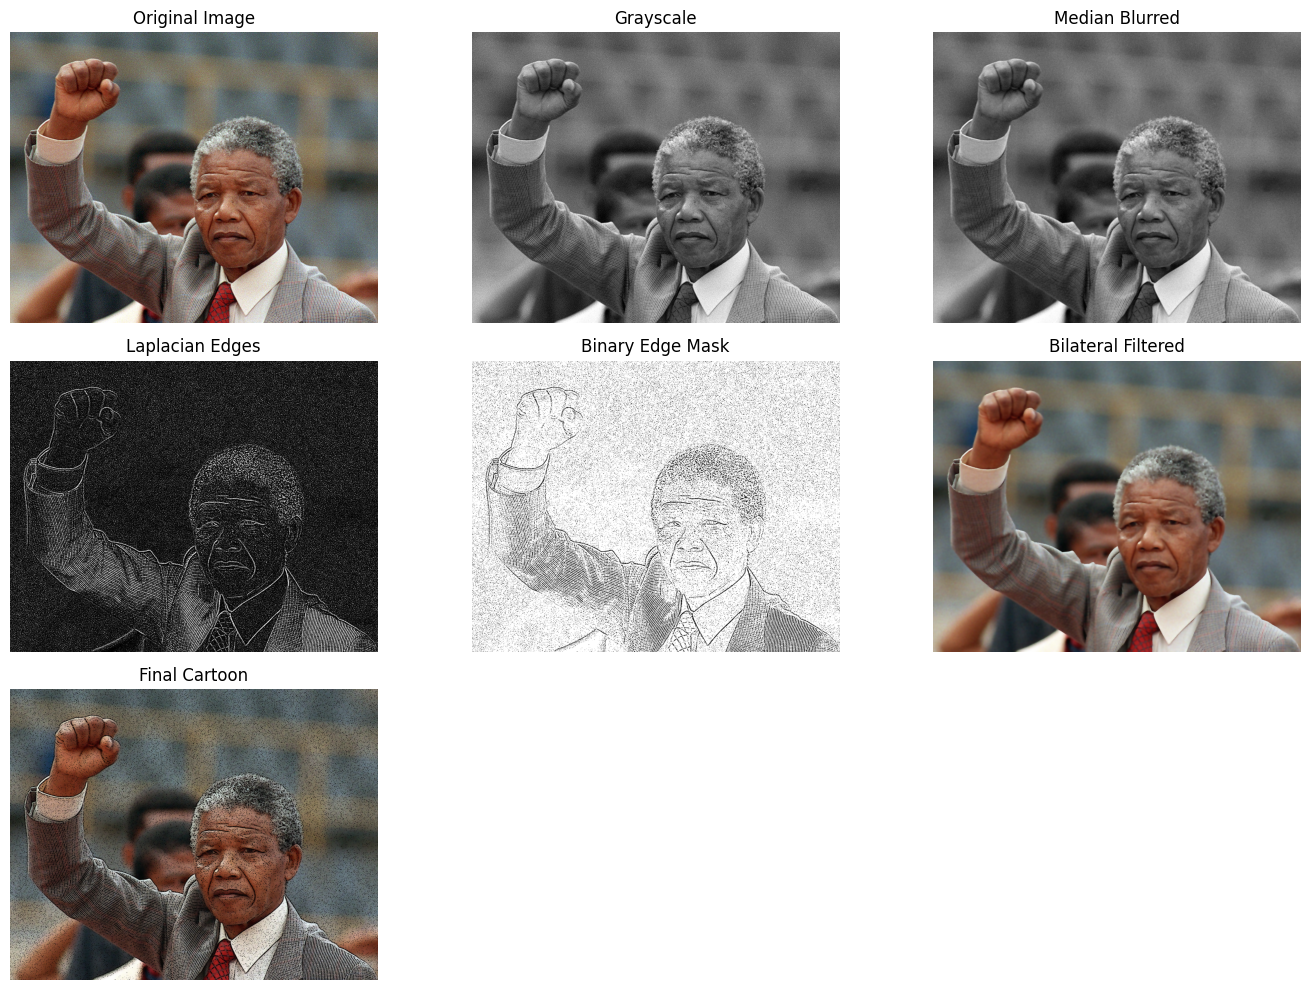

Processing robert.webp


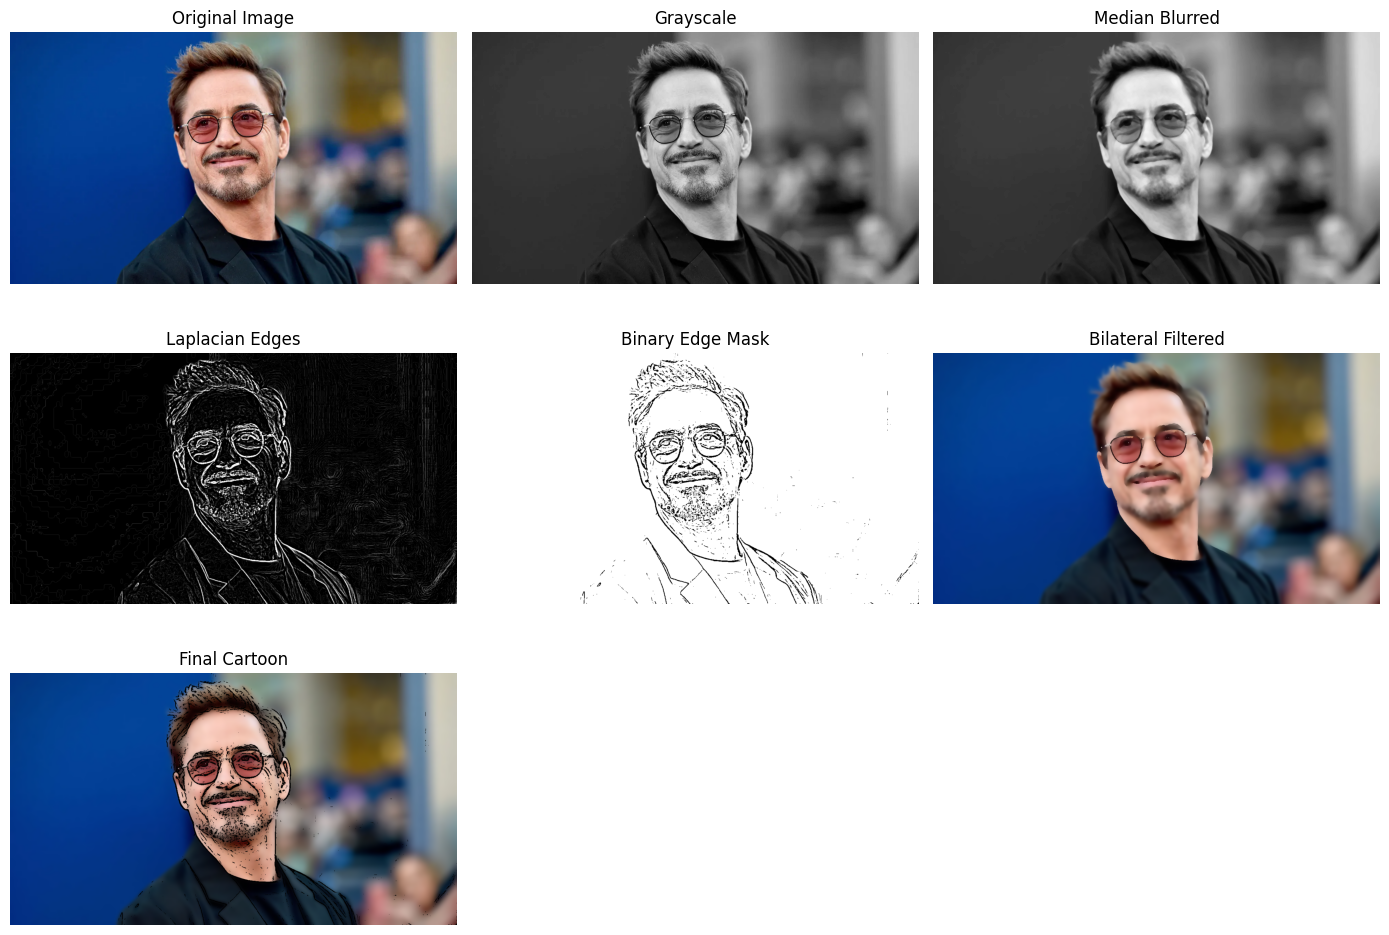

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def cartoonify_image_steps(img, 
                           median_ksize=7, 
                           laplacian_ksize=5, 
                           threshold_val=100,
                           bilateral_d=9, 
                           bilateral_sigmaColor=75, 
                           bilateral_sigmaSpace=75, 
                           num_bilateral=5):
    """
    Process the input image through several steps to obtain a cartoon effect.
    Returns a dictionary of intermediate images.
    Steps:
    1. Original image
    2. Grayscale conversion
    3. Median blurred grayscale image
    4. Laplacian filter result (raw edges)
    5. Binary edge mask (sketch)
    6. Color image after repeated bilateral filtering
    7. Final cartoon image (bilateral filtered image combined with edge mask)
    """
    steps = {}
    steps['original'] = img.copy()
    
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    
    # 2. Apply median filter to reduce noise
    gray_blur = cv2.medianBlur(gray, median_ksize)
    steps['median_blur'] = gray_blur.copy()
    
    # 3. Apply Laplacian filter for edge detection
    laplacian = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=laplacian_ksize)
    steps['laplacian'] = laplacian.copy()
    
    # 4. Apply binary thresholding to create a clear edge mask (sketch)
    ret, edge_mask = cv2.threshold(laplacian, threshold_val, 255, cv2.THRESH_BINARY_INV)
    steps['edge_mask'] = edge_mask.copy()
    
    # 5. Apply repeated bilateral filtering to smooth the color regions while preserving edges
    bilateral_img = img.copy()
    for i in range(num_bilateral):
        bilateral_img = cv2.bilateralFilter(bilateral_img, bilateral_d, bilateral_sigmaColor, bilateral_sigmaSpace)
    steps['bilateral'] = bilateral_img.copy()
    
    # 6. Combine the bilateral filtered image with the edge mask to get the final cartoon effect
    edge_mask_color = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2BGR)
    cartoon = cv2.bitwise_and(bilateral_img, edge_mask_color)
    steps['cartoon'] = cartoon.copy()
    
    return steps

def display_cartoon_steps(steps):
    """
    Displays the intermediate results for the cartoonification process.
    """
    titles = [
        "Original Image", 
        "Grayscale", 
        "Median Blurred", 
        "Laplacian Edges", 
        "Binary Edge Mask", 
        "Bilateral Filtered", 
        "Final Cartoon"
    ]
    
    images = [steps['original'], 
              steps['grayscale'], 
              steps['median_blur'], 
              steps['laplacian'], 
              steps['edge_mask'], 
              steps['bilateral'], 
              steps['cartoon']]
    
    plt.figure(figsize=(14, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)
        # Display grayscale images with a gray colormap
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_cartoonify_folder(folder_path):
    """
    Processes all images in the specified folder using the cartoonification process.
    Saves the intermediate and final outputs to a folder named "cartoon_results".
    """
    # Retrieve all image files from the folder
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))
    output_folder = 'cartoon_results'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error reading image: {image_path}")
            continue
        
        # Process the image
        steps = cartoonify_image_steps(img)
        
        # Create a base name for saving files
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        
        # Save intermediate and final images
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_original.jpg"), steps['original'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_grayscale.jpg"), steps['grayscale'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_median.jpg"), steps['median_blur'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_laplacian.jpg"), steps['laplacian'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_edge_mask.jpg"), steps['edge_mask'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_bilateral.jpg"), steps['bilateral'])
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_cartoon.jpg"), steps['cartoon'])
        
        # Optionally display the results for each image.
        print(f"Processing {os.path.basename(image_path)}")
        display_cartoon_steps(steps)

if __name__ == '__main__':
    folder = 'cartoon_images'  # Folder containing your set of cartoonification input images.
    process_cartoonify_folder(folder)



Median Filter
 - What It Does:
 The median filter is a non-linear filter used primarily for noise reduction. It works exceptionally well at removing “salt and pepper” noise (random bright and dark spots) without blurring the edges as much as linear filters (like Gaussian filters) might.

 - How It Works:

  The filter works by sliding a window (kernel) over the image.
  For each pixel, it considers the intensities of the pixels in the window.
  It then replaces the center pixel’s value with the median value of those intensities.
  Because the median is less sensitive to outliers than the mean, the filter can remove noise while preserving sharp boundaries.

Laplacian Filter
 - What It Does:
 The Laplacian filter is a second-order derivative operator used for edge detection. It highlights areas of rapid intensity change in an image, which typically correspond to edges.

 - How It Works:

 The Laplacian operator computes the second derivative of the image intensity.

 This operation emphasizes regions where the intensity changes rapidly (i.e., edges).
 However, because second derivatives are highly sensitive to noise, applying the Laplacian filter directly to a noisy image could result in many false edges—hence the prior use of the median filter.
 Once the raw edges are computed, a binary threshold is applied to create a sketch-like (black-and-white) effect by converting the grayscale edges into a crisp mask where pixels are either “edge” (white) or “non-edge” (black).

 Bilateral Filter
 - What It Does:
 The bilateral filter is an edge-preserving smoothing filter. It reduces image noise and detail in flat regions while keeping edges sharp.

 - How It Works:

 Unlike traditional filters that consider only the spatial proximity of pixels, the bilateral filter combines both spatial closeness and intensity similarity.
 It applies a weighted average where weights are determined by:
 Domain (Spatial) Weight: A Gaussian function of the distance between the center pixel and the neighboring pixels.
 Range (Intensity) Weight: A Gaussian function of the difference in intensity between the center pixel and its neighbors.

## part 2: Lane Detection

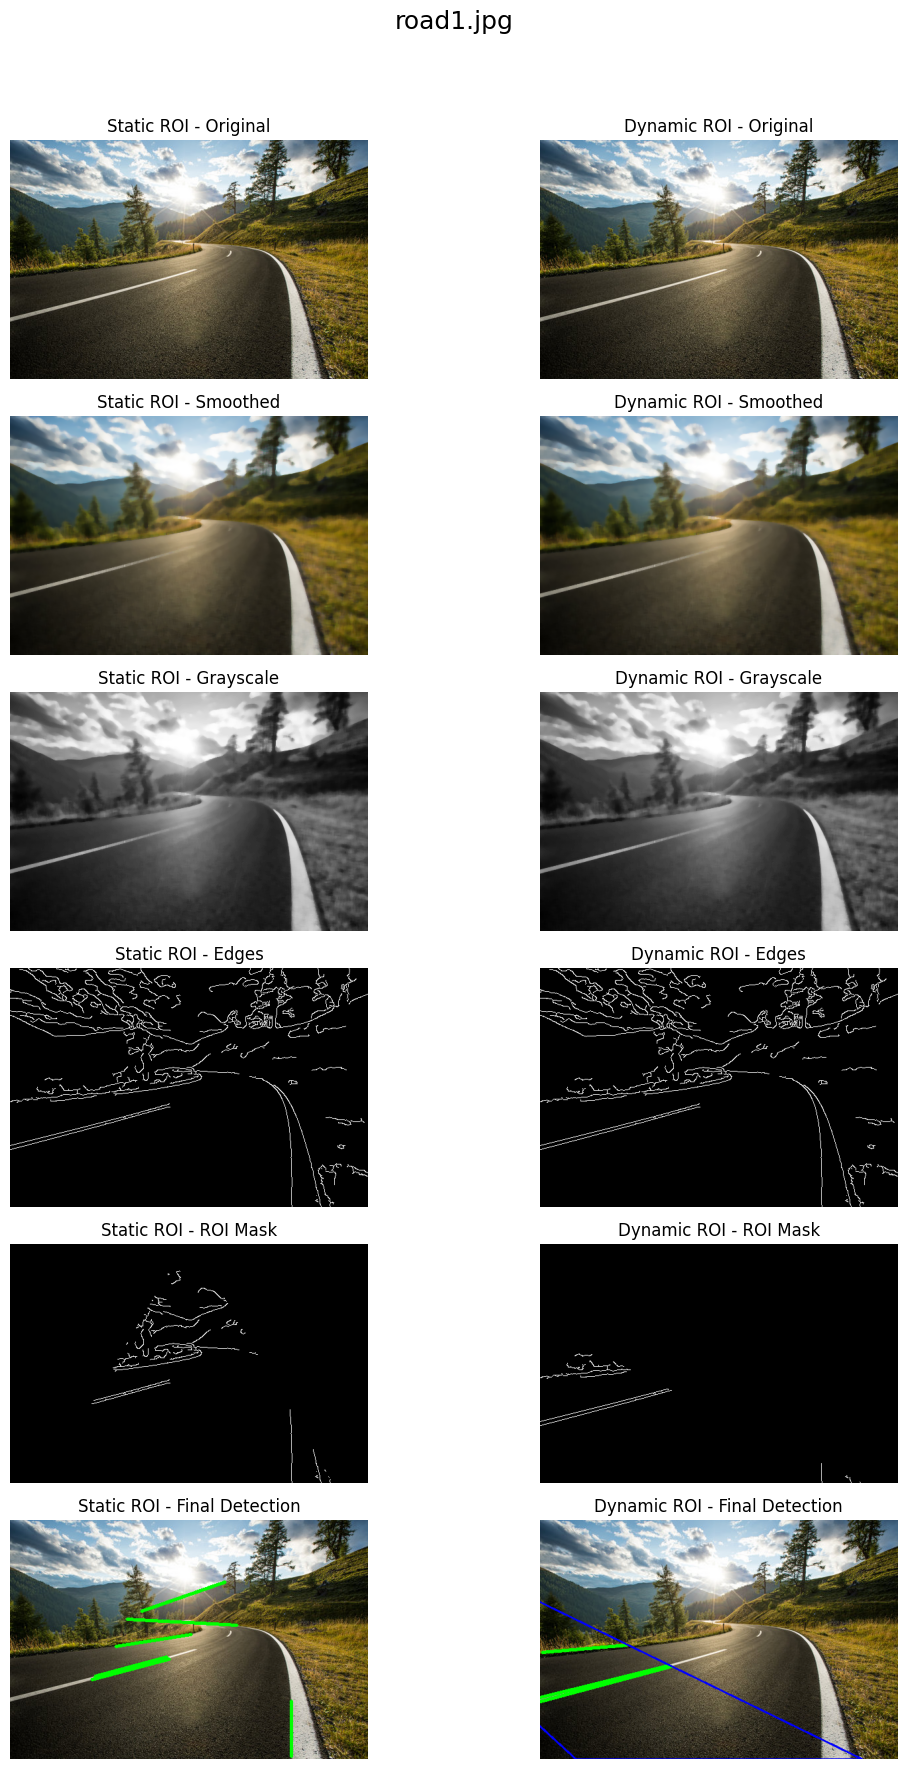

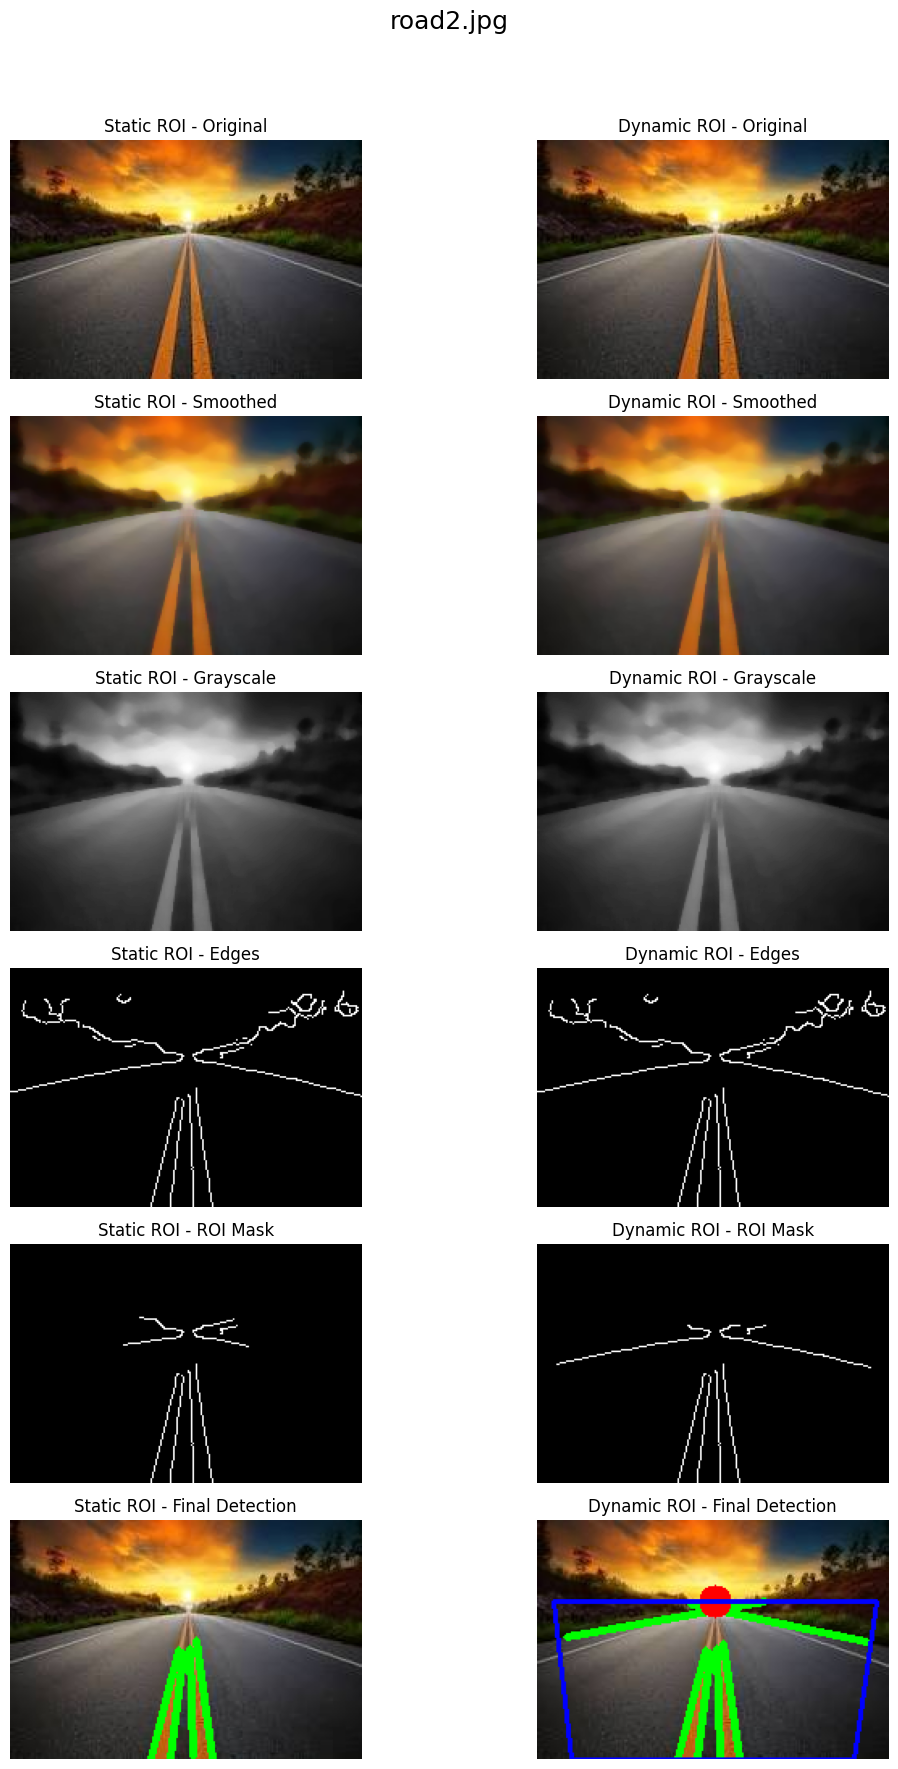

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# -------------------------------
# Static ROI Lane Detection Functions
# -------------------------------

def static_lane_detection_steps(image, median_ksize=7, canny_thresh1=50, canny_thresh2=150, 
                                hough_thresh=50, min_line_length=50, max_line_gap=150):
    """
    Processes the input image using a fixed (static) ROI for lane detection.
    Returns a dictionary containing intermediate results.
    Steps include:
      - Original image
      - Smoothed image (median blur)
      - Grayscale image
      - Edges (Canny)
      - ROI mask (applied on edges)
      - Final lane detection (Hough Transform result)
    """
    steps = {}
    steps['original'] = image.copy()
    
    # 1. Smooth the image using a median filter.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth.copy()
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    
    # 3. Detect edges using the Canny edge detector.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges.copy()
    
    # 4. Define a static (fixed) trapezoidal ROI.
    height, width = edges.shape
    roi_vertices = np.array([[
        (int(0.1 * width), height),                # Bottom left.
        (int(0.45 * width), int(0.1 * height)),      # Top left.
        (int(0.55 * width), int(0.1 * height)),      # Top right.
        (int(0.9 * width), height)                   # Bottom right.
    ]], dtype=np.int32)
    steps['static_roi_vertices'] = roi_vertices.copy()
    
    # 5. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, roi_vertices, 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_static'] = roi_edges.copy()
    
    # 6. Detect lane lines using Hough Transform.
    lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    steps['lane_detection_static'] = lane_img.copy()
    
    return steps

# -------------------------------
# Dynamic ROI Lane Detection Functions
# -------------------------------

def detect_vanishing_point(edges, hough_thresh=50, min_line_length=50, max_line_gap=150):
    """
    Detects the vanishing point by computing intersections of lane lines detected via Hough Transform.
    Returns the averaged intersection point as the vanishing point.
    """
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=hough_thresh, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    if lines is None:
        return None

    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:  # Avoid division by zero.
            continue
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        slopes.append(m)
        intercepts.append(b)
    
    vp_x = []
    vp_y = []
    for i in range(len(slopes)):
        for j in range(i+1, len(slopes)):
            if slopes[i] == slopes[j]:
                continue
            x_intersect = (intercepts[j] - intercepts[i]) / (slopes[i] - slopes[j])
            y_intersect = slopes[i] * x_intersect + intercepts[i]
            vp_x.append(x_intersect)
            vp_y.append(y_intersect)
    
    if len(vp_x) == 0:
        return None

    vanishing_point = (int(np.mean(vp_x)), int(np.mean(vp_y)))
    return vanishing_point

def dynamic_lane_detection_steps(image, median_ksize=7, canny_thresh1=50, canny_thresh2=150, 
                                  hough_thresh=50, min_line_length=50, max_line_gap=150):
    """
    Processes the input image using a dynamic ROI based on the detected vanishing point.
    Returns a dictionary containing intermediate results.
    Steps include:
      - Original image
      - Smoothed image
      - Grayscale image
      - Edges (Canny)
      - Vanishing point detection (used for ROI calculation)
      - ROI mask (applied on edges)
      - Final lane detection (Hough Transform result with vanishing point overlaid)
    """
    steps = {}
    steps['original'] = image.copy()
    
    # 1. Smooth the image.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth.copy()
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    
    # 3. Detect edges using Canny.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges.copy()
    
    # 4. Detect vanishing point.
    vp = detect_vanishing_point(edges, hough_thresh, min_line_length, max_line_gap)
    steps['vanishing_point'] = vp  # This is just stored for reference.
    
    # 5. Define a dynamic ROI based on the vanishing point.
    height, width = edges.shape
    if vp is None:
        roi_vertices = np.array([[
            (int(0.1 * width), height),
            (int(0.4 * width), int(0.1* height)),
            (int(0.6 * width), int(0.1 * height)),
            (int(0.9 * width), height)
        ]], dtype=np.int32)
    else:
        vp_x, vp_y = vp
        roi_vertices = np.array([[
            (int(0.1 * width), height),
            (vp_x - 100, vp_y ),
            (vp_x + 100, vp_y ),
            (int(0.9 * width), height)
        ]], dtype=np.int32)
    steps['dynamic_roi_vertices'] = roi_vertices.copy()
    
    # 6. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, roi_vertices, 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_dynamic'] = roi_edges.copy()
    
    # 7. Detect lane lines using Hough Transform.
    lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=hough_thresh, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    # Overlay the vanishing point if detected.
    if vp is not None:
        cv2.circle(lane_img, vp, 10, (0, 0, 255), -1)
    cv2.polylines(lane_img, [roi_vertices], True, (255, 0, 0), 2)
    steps['lane_detection_dynamic'] = lane_img.copy()
    
    return steps

# -------------------------------
# Display Function for Intermediate Steps Comparison
# -------------------------------

def display_lane_intermediate_comparison(static_steps, dynamic_steps, image_title="Intermediate Comparison"):
    """
    Displays a side-by-side comparison of all intermediate steps for static and dynamic ROI approaches.
    The grid has 6 rows (Original, Smoothed, Grayscale, Edges, ROI Mask, Final Detection)
    and 2 columns (Static ROI on the left, Dynamic ROI on the right).
    """
    steps_names = ["Original", "Smoothed", "Grayscale", "Edges", "ROI Mask", "Final Detection"]
    static_keys = ["original", "smoothed", "grayscale", "edges", "roi_edges_static", "lane_detection_static"]
    dynamic_keys = ["original", "smoothed", "grayscale", "edges", "roi_edges_dynamic", "lane_detection_dynamic"]

    plt.figure(figsize=(12, 18))
    for i in range(len(steps_names)):
        # Static ROI column (left)
        plt.subplot(len(steps_names), 2, 2*i+1)
        img_static = static_steps[static_keys[i]]
        if len(img_static.shape) == 2:
            plt.imshow(img_static, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img_static, cv2.COLOR_BGR2RGB))
        plt.title(f"Static ROI - {steps_names[i]}")
        plt.axis("off")
        
        # Dynamic ROI column (right)
        plt.subplot(len(steps_names), 2, 2*i+2)
        img_dynamic = dynamic_steps[dynamic_keys[i]]
        if len(img_dynamic.shape) == 2:
            plt.imshow(img_dynamic, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img_dynamic, cv2.COLOR_BGR2RGB))
        plt.title(f"Dynamic ROI - {steps_names[i]}")
        plt.axis("off")
        
    plt.suptitle(image_title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# -------------------------------
# Process a Folder of Images
# -------------------------------

def process_lane_images_folder(folder_path):
    """
    Processes all images in the specified folder using both static and dynamic ROI lane detection.
    Displays all intermediate steps and saves the final outputs.
    """
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))
    output_folder = 'lane_results'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        
        static_steps = static_lane_detection_steps(image)
        dynamic_steps = dynamic_lane_detection_steps(image)
        title = os.path.basename(image_path)
        
        # Display intermediate comparisons.
        display_lane_intermediate_comparison(static_steps, dynamic_steps, image_title=title)
        
        # Save the final lane detection outputs.
        cv2.imwrite(os.path.join(output_folder, f'static_{title}'), static_steps['lane_detection_static'])
        cv2.imwrite(os.path.join(output_folder, f'dynamic_{title}'), dynamic_steps['lane_detection_dynamic'])

# -------------------------------
# Main Execution
# -------------------------------

if __name__ == '__main__':
    folder = 'road_images'  # Folder containing your set of road images.
    process_lane_images_folder(folder)
